<a href="https://colab.research.google.com/github/KnyazevAV/hangman/blob/master/RecSys_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Произведем загрузку необходимых библиотек**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#библиотека, которую мы будем использовать для опредения оптимального количества кластеров "методом локтя"
!pip install kneed 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#работа с данными
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn import preprocessing
import scipy
import numpy as np
from sklearn.model_selection import train_test_split

#построение модели нейронной коллаборативной фильтрации
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input
from IPython.display import SVG
import tensorflow as tf

#визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

#кластеризация данных
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator

#формирование нейросети
from keras.layers import Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

# **Обработка данных**

Произведем загрузку данных
Ссылка на датасет на kaggle: https://www.kaggle.com/datasets/tamber/steam-video-games/code?select=steam-200k.csv

Я загружаю данные с google drive.

In [7]:
path = '/content/drive/My Drive/Recommendation System/steam-200k.csv'
df = pd.read_csv(path, names=['userId', 'game', 'action', 'duration', 'unknown'])

In [8]:
df

,userId,game,action,duration,unknown
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
...,...,...,...,...,...
199995,128470551,Titan Souls,play,1.5,0
199996,128470551,Grand Theft Auto Vice City,purchase,1.0,0
199997,128470551,Grand Theft Auto Vice City,play,1.5,0
199998,128470551,RUSH,purchase,1.0,0


Будем выстраивать рекомендательную систему опираясь на количество часов наигранных пользователями

In [9]:
df = df[df.action=='play'] #уберем действие "покупка", оставим только действие "игра"
df = df.reset_index()
df = df.drop(columns=['index'])
df

,userId,game,action,duration,unknown
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,play,87.0,0
2,151603712,Spore,play,14.9,0
3,151603712,Fallout New Vegas,play,12.1,0
4,151603712,Left 4 Dead 2,play,8.9,0
...,...,...,...,...,...
70484,128470551,Fallen Earth,play,2.4,0
70485,128470551,Magic Duels,play,2.2,0
70486,128470551,Titan Souls,play,1.5,0
70487,128470551,Grand Theft Auto Vice City,play,1.5,0


In [10]:
#уберем лишний столбец, если там все значения одинаковые
if len(df.unknown.unique()) == 1:
  df = df.drop(columns=['unknown'])

In [11]:
#сгруппирурем данные по типу игры и посмотрим, сколько потрачено времени на каждую игру
group = df.groupby(['game']).sum().duration
#выведем топ-20 игр по времени игры пользователей
group = group.sort_values(ascending=False)[:20]
group

game
Dota 2                                         981684.6
Counter-Strike Global Offensive                322771.6
Team Fortress 2                                173673.3
Counter-Strike                                 134261.1
Sid Meier's Civilization V                      99821.3
Counter-Strike Source                           96075.5
The Elder Scrolls V Skyrim                      70889.3
Garry's Mod                                     49725.3
Call of Duty Modern Warfare 2 - Multiplayer     42009.9
Left 4 Dead 2                                   33596.7
Football Manager 2013                           32308.6
Football Manager 2012                           30845.8
Football Manager 2014                           30574.8
Terraria                                        29951.8
Warframe                                        27074.6
Football Manager 2015                           24283.1
Arma 3                                          24055.7
Grand Theft Auto V                         

Посмотрим насколько большой разброс данных в столбце duration, по которому будем выстраивать систему рейтинга

<AxesSubplot:xlabel='duration', ylabel='Density'>

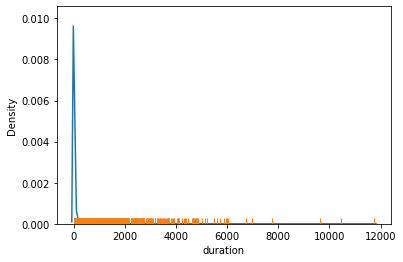

In [12]:
sns.kdeplot(df["duration"])
sns.rugplot(df["duration"])


Визуально можно оценить, что наиболее плотно данные расположены в пределах 2000 часов игры. Сравним насколько сильно отличается размер датасета до 2000 и до 4000 часов в стобце duration. Отсечем все случаи, когда user играл в игру меньше 1 часа.

In [13]:
df_2000 = df[df.duration<=2000]
df_2000 = df_2000[df_2000.duration>=1]
df_2000 = df_2000.reset_index() #создадим стобец index для визуализации

In [14]:
df_2000

,index,userId,game,action,duration
0,0,151603712,The Elder Scrolls V Skyrim,play,273.0
1,1,151603712,Fallout 4,play,87.0
2,2,151603712,Spore,play,14.9
3,3,151603712,Fallout New Vegas,play,12.1
4,4,151603712,Left 4 Dead 2,play,8.9
...,...,...,...,...,...
53516,70484,128470551,Fallen Earth,play,2.4
53517,70485,128470551,Magic Duels,play,2.2
53518,70486,128470551,Titan Souls,play,1.5
53519,70487,128470551,Grand Theft Auto Vice City,play,1.5


Визулизируем разброс данных duration в завивисимости от index.

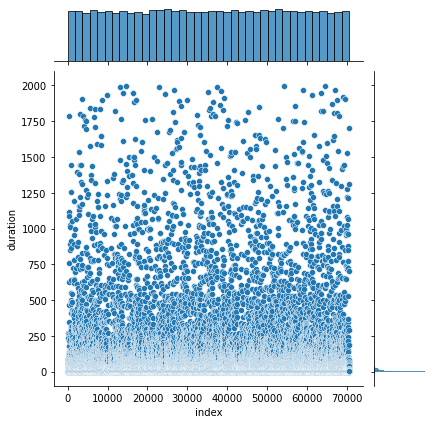

In [15]:
sns.jointplot(x = 'index', y = 'duration', data = df_2000)

In [16]:
#сгруппирурем данные по типу игры и посмотрим, сколько потрачено времени на каждую игру
group_2000 = df_2000.groupby(['game']).sum().duration
#выведем топ-20 игр по времени игры пользователей
group_2000 = group_2000.sort_values(ascending=False)[:20]
group_2000

game
Dota 2                                         630314.3
Counter-Strike Global Offensive                297485.3
Team Fortress 2                                141432.8
Counter-Strike                                  79426.1
Counter-Strike Source                           75990.4
The Elder Scrolls V Skyrim                      70872.3
Sid Meier's Civilization V                      61171.3
Garry's Mod                                     46036.1
Call of Duty Modern Warfare 2 - Multiplayer     41995.4
Terraria                                        29929.9
Left 4 Dead 2                                   28791.4
Football Manager 2012                           28757.5
Warframe                                        27044.9
Football Manager 2013                           26684.1
Football Manager 2014                           23520.8
Grand Theft Auto V                              22955.1
Borderlands 2                                   22653.5
Football Manager 2015                      

In [17]:
df_4000 = df[df.duration<=4000]
df_4000 = df_4000[df_4000.duration>=1]
df_4000 = df_4000.reset_index() #создадим стобец index для визуализации

In [18]:
df_4000

,index,userId,game,action,duration
0,0,151603712,The Elder Scrolls V Skyrim,play,273.0
1,1,151603712,Fallout 4,play,87.0
2,2,151603712,Spore,play,14.9
3,3,151603712,Fallout New Vegas,play,12.1
4,4,151603712,Left 4 Dead 2,play,8.9
...,...,...,...,...,...
53654,70484,128470551,Fallen Earth,play,2.4
53655,70485,128470551,Magic Duels,play,2.2
53656,70486,128470551,Titan Souls,play,1.5
53657,70487,128470551,Grand Theft Auto Vice City,play,1.5


Визулизируем разброс данных duration в завивисимости от index.


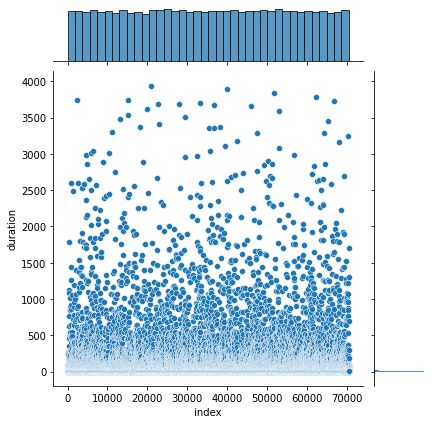

In [19]:
sns.jointplot(x = 'index', y = 'duration', data = df_4000)

In [20]:
#сгруппирурем данные по типу игры и посмотрим, сколько потрачено времени на каждую игру
group_4000 = df_4000.groupby(['game']).sum().duration
#выведем топ-20 игр по времени игры пользователей
group_4000 = group_4000.sort_values(ascending=False)[:20]
group_4000

game
Dota 2                                         860933.3
Counter-Strike Global Offensive                314065.3
Team Fortress 2                                163760.8
Counter-Strike                                 120517.1
Counter-Strike Source                           86955.4
The Elder Scrolls V Skyrim                      70872.3
Sid Meier's Civilization V                      65836.3
Garry's Mod                                     49703.1
Call of Duty Modern Warfare 2 - Multiplayer     41995.4
Left 4 Dead 2                                   33556.4
Football Manager 2013                           32307.1
Football Manager 2012                           30845.5
Terraria                                        29929.9
Warframe                                        27044.9
Football Manager 2014                           25799.8
Football Manager 2015                           24283.1
Arma 3                                          24053.3
Grand Theft Auto V                         

In [21]:
compare_2000_4000 = pd.concat([group_2000, group_4000, group], axis=1)
compare_2000_4000

,duration,duration,duration
game,,,
Dota 2,630314.3,860933.3,981684.6
Counter-Strike Global Offensive,297485.3,314065.3,322771.6
Team Fortress 2,141432.8,163760.8,173673.3
Counter-Strike,79426.1,120517.1,134261.1
Counter-Strike Source,75990.4,86955.4,96075.5
The Elder Scrolls V Skyrim,70872.3,70872.3,70889.3
Sid Meier's Civilization V,61171.3,65836.3,99821.3
Garry's Mod,46036.1,49703.1,49725.3
Call of Duty Modern Warfare 2 - Multiplayer,41995.4,41995.4,42009.9


Вывод: разница между df_2000 и df_4000 незначительно. Визуально у df_4000 разброс данных больше. Работаем с df_2000. Если сравнить по топ-20 игр, видим, что они не поменялись в целом, но поменялись местами.

**Проведем кластеризацию данных**

Просуммируем все случаи, когда один и тот же user играет в одну и ту же игру

Переформотируем датасет в формат userId - game - duration 
(просуммируем время игры каждого пользователя в конкретную игру)

создадим gameId от 1 до количества игр в датасете и переобозначим userId от 1 до количества пользователей в датасете


In [22]:
game_dict = {}
id = 1

for index, row in df_2000.iterrows():
    if game_dict.get(row['game']) is None:
        game_dict[row['game']] = id
        df_2000.at[index, 'gameId'] = id
        id += 1
    else:
        df_2000.at[index, 'gameId'] = game_dict.get(row['game'])

In [23]:
user_dict = {}
id = 1

for index, row in df_2000.iterrows():
    if user_dict.get(row['userId']) is None:
        user_dict[row['userId']] = id
        df_2000.at[index, 'userId'] = id
        id += 1
    else:
        df_2000.at[index, 'userId'] = user_dict.get(row['userId'])

In [ ]:
df_2000.gameId = df_2000.gameId.values.astype(np.int)

<ipython-input-29-ab8e1963082a>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_2000.gameId = df_2000.gameId.values.astype(np.int)


Создадим вспомогательный стобец sessionId для суммирования повторов, когда в таблице 1 и тот же пользователь играет в одну и ту же игру (такие ситуации присутствуют в данном датасете в небольшом количестве).

In [ ]:
df_2000['sessionId'] = df_2000.apply(lambda row: str(row['gameId']) + str(row['userId']), axis=1) #созданием sessionID

In [ ]:
df_2000 = df_2000.drop(columns=['index', 'game', 'action'])

In [ ]:
df_2000

,userId,duration,gameId,sessionId
0,1,273.0,1,11
1,1,87.0,2,21
2,1,14.9,3,31
3,1,12.1,4,41
4,1,8.9,5,51
...,...,...,...,...
53516,9555,2.4,1152,11529555
53517,9555,2.2,1008,10089555
53518,9555,1.5,2374,23749555
53519,9555,1.5,1003,10039555


In [ ]:
#создадим так же вспомогательный список по которому будем циклом проводить суммирование
sessionId_sorted = df_2000.sessionId.unique() 
sessionId_sorted, len(sessionId_sorted)

(array(['11', '21', '31', ..., '23749555', '10039555', '1969555'],
       dtype=object), 53401)

In [ ]:
#суммируем все повторы
new_data = pd.DataFrame()
for i in range(len(sessionId_sorted)):
  if len(df_2000[df_2000.sessionId==sessionId_sorted[i]]) != 1:
    new_data = new_data.append({'userId': df_2000[df_2000.sessionId==sessionId_sorted[i]].userId.iloc[0], 
                             'duration': df_2000[df_2000.sessionId==sessionId_sorted[i]].duration.sum(), 
                             'gameId': df_2000[df_2000.sessionId==sessionId_sorted[i]].gameId.iloc[0], 
                             'sessionId': df_2000[df_2000.sessionId==sessionId_sorted[i]].sessionId.iloc[0]}, ignore_index=True)
  else:
    new_data = new_data.append(df_2000[df_2000.sessionId==sessionId_sorted[i]], ignore_index=True)

In [ ]:
#нормализуем данные в столбце duration для лучшей кластеризации
data = new_data.copy()
data = data.drop(columns=['sessionId'])
arr = np.array([data.duration])
duration_n = normalize(arr) 

duration_n_list = []
for i in duration_n[0]:
  duration_n_list.append(i)

data['dur_norm'] = duration_n_list
data.head()

,userId,duration,gameId,dur_norm
0,1,273.0,1,0.006890
1,1,87.0,2,0.002196
2,1,14.9,3,0.000376
3,1,12.1,4,0.000305
4,1,8.9,5,0.000225


In [ ]:
#удалим ненужные для кластеризации столбцы
#сформируем датасет userId, gameId, dur_norm
data = data.drop(columns=['duration'])
data

,userId,gameId,dur_norm
0,1,1,0.006890
1,1,2,0.002196
2,1,3,0.000376
3,1,4,0.000305
4,1,5,0.000225
...,...,...,...
53396,9555,1152,0.000061
53397,9555,1008,0.000056
53398,9555,2374,0.000038
53399,9555,1003,0.000038


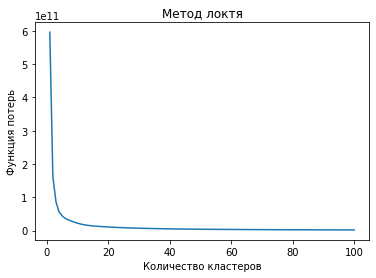

Оптимальное количество кластеров: 6


In [ ]:
#список для хранения значений функции потерь
loss = []

#используем цикл для обучения моделей с разным количеством кластеров и расчета значения функции потерь
for i in range(1, 101):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data)
    loss.append(kmeans.inertia_)

#построим график функции потерь
plt.plot(range(1, 101), loss)
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Функция потерь')
plt.show()

#используем библиотеку kneed для нахождения оптимального количества кластеров
kl = KneeLocator(range(1, 101), loss, curve='convex', direction='decreasing')
print(f'Оптимальное количество кластеров: {kl.elbow}')

Начнем кластеризацию

In [ ]:
#стандартизируем данные
x = np.nan_to_num(data)
Clust_dataset=StandardScaler().fit_transform(x)

clasterNum = 6
k_means = KMeans(init="k-means++", n_clusters=clasterNum, n_init=12)
k_means.fit(Clust_dataset)
labels=k_means.labels_

In [ ]:
#сравним длину labels и нашего датасета
len(labels), len(data)

(53401, 53401)

In [ ]:
#проверим, кол-во кластеров
unique_numbers = list(set(labels))
print(unique_numbers)

[0, 1, 2, 3, 4, 5]


In [ ]:
#сделаем датафрейм кластеров, чтобы потом соединить его с основным датафреймом
df_labels = pd.DataFrame(labels, columns=['cluster'])
df_labels.isna().sum()

cluster    0
dtype: int64

In [ ]:
#сделаем индексы для датафрейма лэйблов таким же, как у исходного датафрейма для более простого соединения
indexes = data.index
indexes
df_labels.index = indexes
df_labels

,cluster
0,4
1,4
2,4
3,4
4,4
...,...
53396,2
53397,2
53398,1
53399,2


In [ ]:
#дополняем основной датафрейм кластерами
data_clust = pd.merge(left=data, right=df_labels, left_index=True, right_index=True)
data_clust

,userId,gameId,dur_norm,cluster
0,1,1,0.006890,4
1,1,2,0.002196,4
2,1,3,0.000376,4
3,1,4,0.000305,4
4,1,5,0.000225,4
...,...,...,...,...
53396,9555,1152,0.000061,2
53397,9555,1008,0.000056,2
53398,9555,2374,0.000038,1
53399,9555,1003,0.000038,2


In [ ]:
data_clust.isna().sum()

userId      0
gameId      0
dur_norm    0
cluster     0
dtype: int64

In [ ]:
#посмотрим распределение кластеров
cluster_count = data_clust['cluster'].value_counts()
cluster_count

2    21029
4    19358
0     7001
1     3720
3     1744
5      549
Name: cluster, dtype: int64

In [ ]:
#на всякий случай сохраним финальный датасет 
data_clust_saved = data_clust.to_csv('data_clust.csv')


In [26]:
data_clust = pd.read_csv('/content/data_clust-2 екгу.csv')
data_clust = data_clust.drop(columns=['Unnamed: 0'])
data_clust.head()

,userId,gameId,dur_norm,cluster
0,1,1,0.006890,4
1,1,2,0.002196,4
2,1,3,0.000376,4
3,1,4,0.000305,4
4,1,5,0.000225,4


In [27]:
#обозначим количество пользователей и количество игр
num_users = len(data_clust.userId.unique())
num_games = len(data_clust.gameId.unique())
num_users, num_games

(9523, 3074)

In [31]:
from sklearn. model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=40)
test = splitter.split(data_clust, groups=['userId'])

In [32]:
test

<generator object BaseShuffleSplit.split at 0x7fa4d0482f20>

In [33]:
train, validate, test = np.split(data_clust, [int(.7*len(data_clust)), int(.85*len(data_clust))])

In [37]:
train_userId = set(train['userId'].values)
val_userId = set(validate['userId'].values)
test_userId = set(validate['userId'].values)

print("%s different users in the training set" % len(train_userId))
print("%s different users in the val set" % len(val_userId))
print("%s different users in the testing set" % len(test_userId))
print("%s owners appear in both sets" % len(train_userId.intersection(val_userId)))
print("%s owners appear in both sets" % len(train_userId.intersection(test_userId)))

6576 different users in the training set
1428 different users in the val set
1428 different users in the testing set
1 owners appear in both sets
1 owners appear in both sets


# **Нейронная коллаборативная фильтрация**

Нейронная коллаборативная фильтрация (Neural Collaborative Filtering) — это использование нейронной сети определенной архитектуры для моделирования на основе имеющейся информации собственных векторов объектов (в нашем случае игр) и пользователей, а также изучения функции, описывающей их взаимодействие, на основе которой и составляются рекомендации.

Структура и визуализация модели

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


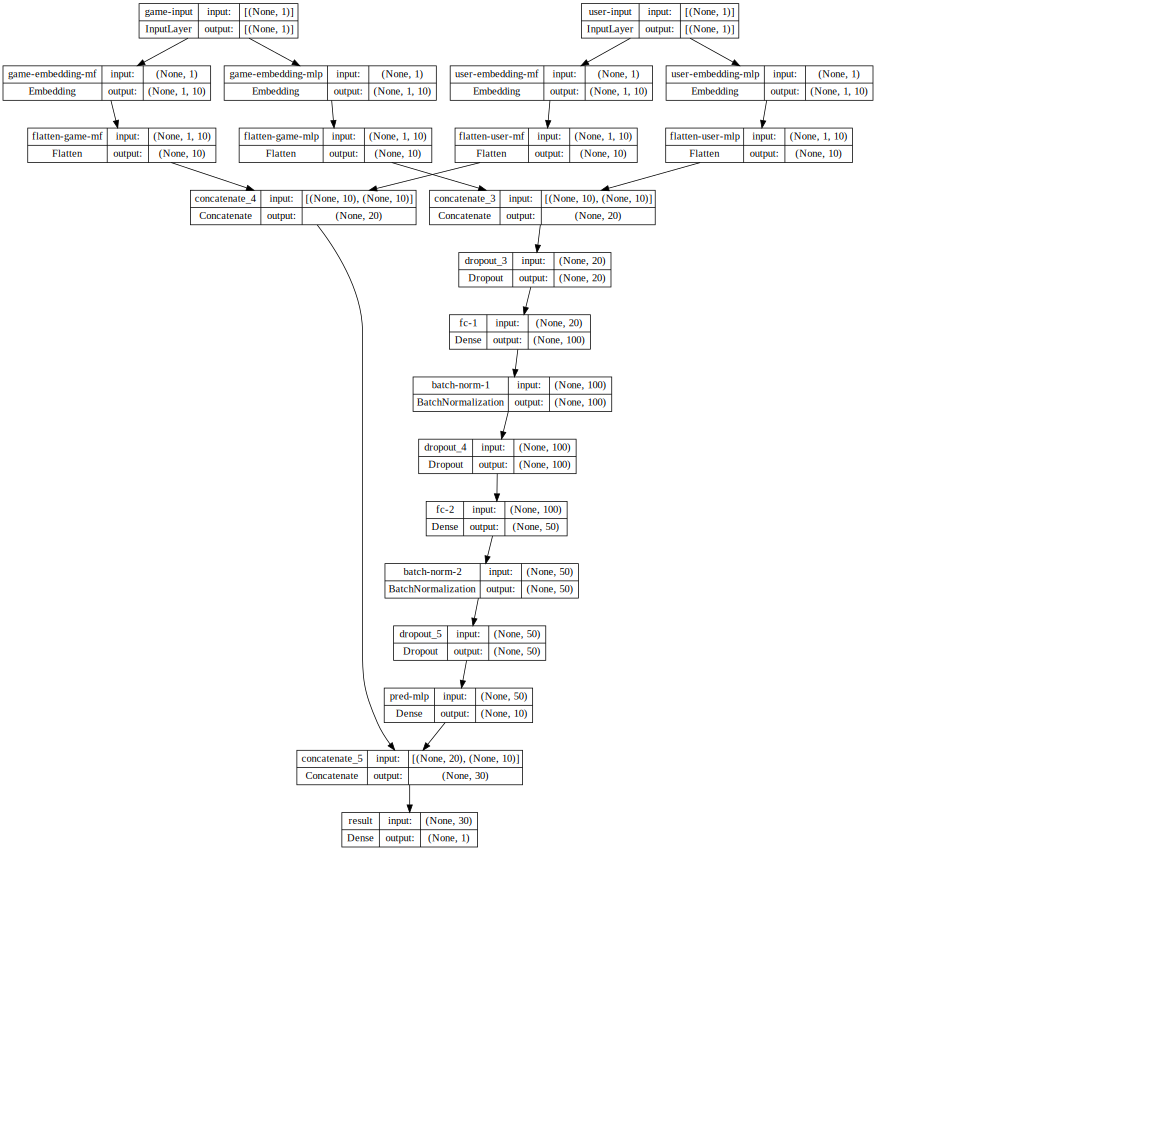

In [53]:
latent_dim = 10

game_input = Input(shape= (1, ),name='game-input')
user_input = Input(shape=[1], name='user-input')

game_embedding_mlp = Embedding(num_games+1, latent_dim, name='game-embedding-mlp')(game_input)
game_vec_mlp = Flatten(name='flatten-game-mlp')(game_embedding_mlp)

user_embedding_mlp = Embedding(num_users+1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

game_embedding_mf = Embedding(num_games+1, latent_dim, name='game-embedding-mf')(game_input)
game_vec_mf = Flatten(name='flatten-game-mf')(game_embedding_mf)

user_embedding_mf = Embedding(num_users+1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

concat = tf.keras.layers.Concatenate()([game_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

#прогноз из обоих слоев
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = tf.keras.layers.Concatenate()([game_vec_mf, user_vec_mf])
combine_mlp_mf = tf.keras.layers.Concatenate()([pred_mf, pred_mlp])

#финальный слой
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, game_input], result)
model.compile(optimizer=Adam(lr=0.01), loss='mean_absolute_error')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 game-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 game-embedding-mlp (Embedding)  (None, 1, 10)       30750       ['game-input[0][0]']             
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 10)       95240       ['user-input[0][0]']             
                                                                                            

Epoch 1/10
585/585 [==============================] - 14s 17ms/step - loss: 0.7107
Epoch 2/10
585/585 [==============================] - 5s 8ms/step - loss: 0.3947
Epoch 3/10
585/585 [==============================] - 6s 10ms/step - loss: 0.3448
Epoch 4/10
585/585 [==============================] - 6s 10ms/step - loss: 0.3002
Epoch 5/10
585/585 [==============================] - 4s 6ms/step - loss: 0.2871
Epoch 6/10
585/585 [==============================] - 6s 9ms/step - loss: 0.2811
Epoch 7/10
585/585 [==============================] - 4s 7ms/step - loss: 0.2651
Epoch 8/10
585/585 [==============================] - 4s 7ms/step - loss: 0.2662
Epoch 9/10
585/585 [==============================] - 6s 10ms/step - loss: 0.2526
Epoch 10/10
585/585 [==============================] - 4s 7ms/step - loss: 0.2550


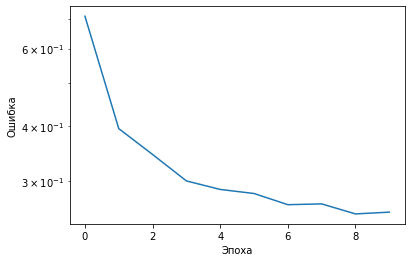

251/251 [==============================] - 1s 2ms/step


1.3674756676709738

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.userId, train.gameId], train.cluster, epochs=10, batch_size=64)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.show()

y_hat = np.round(model.predict([validate.userId, validate.gameId]), decimals=2)
y_true = validate.cluster
mean_absolute_error(y_true, y_hat)

# **Проверка работы модели**

Создадим вспомогательные словария для предсказания рекомендаций

In [56]:
game_ids = data_clust['gameId'].unique().tolist() #делаем список игр
game2game_encoded = {x: i for i, x in enumerate(game_ids)} #делаем словарь, где каждому ID игры присваиваем индекс 
game_encoded2game = {i: x for i, x in enumerate(game_ids)} #переводим ранее сформированный словарь gameId-index в формат index-gameId


Создадим вспомогательные словария для предсказания рекомендаций

In [12]:
user_ids = data_clust['userId'].unique().tolist() #делаем список пользователей
user2user_encoded = {x: i for i, x in enumerate(user_ids)} #делаем словарь, где каждому ID пользователя присваиваем индекс 
userencoded2user = {i: x for i, x in enumerate(user_ids)} #переводим ранее сформированный словарь userId-index в формат index-ID

In [13]:
#функция инвертирования словаря для вывода названий рекомендованных игр
def invert(d):
    return {v: k for k, v in d.items()}

In [ ]:
invert(user_dict)[9555]

128470551

In [67]:
user_id = 128470551


In [68]:
user_id = user_dict[user_id]
user_id

9555

In [ ]:
#функция инвертирования словаря для вывода названий рекомендованных игр
def invert_userId(d):
    return {v: k for k, v in d.items()}

In [77]:
1 in user_dict

False

Надо помнить, что датасет test был сформирован с уже измененным userId. Подавать на вход мы будем реальные значения, которые будут взяты из словаря user_dict

In [78]:
def pred(data, user_id, k, all_data):

  #data - данные за какой-то период времени
  #user_id - id пользователя, который зашел в систему
  #k - число выдаваемых рекомендаций
  #all_data - датасет за весь период для формирования рекомендаций самых популярных игр (по продолжительности игры)

  #переведем user_id из изначального значения в конвертированное, на которых строилась и обучалась модель
  if user_id in user_dict:
    user_id = user_dict[user_id]

    #создадим вспомогательный список всех юзеров в колонке userId, через него будем опредедять новый пользователь или нет
    l_temp = []
    for i in data.userId:
      l_temp.append(i)

    #задаем количество выводимых рекомендованных стримеров
    if user_id in l_temp: #если пользователь заходил и смотрел что-то, предсказываем рекомендации
      games_watched_by_user = data[data.userId == user_id] #стримеры, которых смотрел пользователь
      #стримеры, которых не смотрел пользователь
      games_not_watched = data[~data["gameId"].isin(games_watched_by_user.gameId.values)]["gameId"]
      games_not_watched = list(set(games_not_watched).intersection(set(game2game_encoded.keys())))
      games_not_watched = np.array([game2game_encoded.get(x) for x in games_not_watched])

      user_encoder = user2user_encoded.get(user_id) #вычисляем индекс userId
      user_game_array_user = np.array([user_encoder] * len(games_not_watched))
      ratings = model.predict([user_game_array_user, games_not_watched]).flatten() #делаем предсказание рейтинга
      top_ratings_indices = ratings.argsort()[-k:][::-1] #выбираем 10 индексов стримеров для "нашего" пользователя, с наивысшим предсказанным рейтингом

      #переводим индекс в gameId
      recommended_games_ids = [game_encoded2game.get(games_not_watched[x]) for x in top_ratings_indices] 
      #формируем список топ 10 стримеров
      rec_games = []
      for i in recommended_games_ids:
        rec_games.append(invert(game_dict)[i])
      return rec_games

    else: #если пользователь новый, показываем 10 наиболее популярных каналов
    #формируем список популярных каналов
      temp = all_data.groupby(['game']).sum().duration.sort_values(ascending=False)[:k]
    
      rec_games = []

      for i in temp.index:
        rec_games.append(i)

      return rec_games
  
  else:
    temp = all_data.groupby(['game']).sum().duration.sort_values(ascending=False)[:k]
      
    rec_games = []

    for i in temp.index:
      rec_games.append(i)

    return rec_games


In [58]:
#посмотрим какие юзеры попали в тестовую выборку, что сделать по ним предсказание
test

,userId,gameId,dur_norm,cluster
45390,8033,239,0.002928,2
45391,8033,79,0.002700,2
45392,8033,31,0.002599,2
45393,8033,245,0.002297,2
45394,8033,87,0.002297,2
...,...,...,...,...
53396,9555,1152,0.000061,2
53397,9555,1008,0.000056,2
53398,9555,2374,0.000038,1
53399,9555,1003,0.000038,2


Поскольку у нас переобозначены userId, будем вводить корректные значения из первоначального датасета, а функция pred будет переводить их в значения, на которых переобучалась модель

In [75]:
invert(user_dict)[8033], user_dict[26762388]

(26762388, 8033)

In [79]:
#проверим пользователя, которого мы видим в тестовом датасете
print(pred(test, invert(user_dict)[8033], 10, df))

42/42 [==============================] - 0s 3ms/step
['Botanicula', 'Stacking', 'Age of Empires III Complete Collection', 'Valiant Hearts The Great War / Soldats Inconnus  Mmoires de la Grande Guerre', 'Insurgency Modern Infantry Combat', 'SteamWorld Dig', 'Resident Evil 5 / Biohazard 5', 'Trials Evolution Gold Edition', 'Back to the Future Ep 3 - Citizen Brown', 'Rocketbirds Hardboiled Chicken']


In [80]:
#проверим еще одного пользователя, которого мы видим в тестовом датасете
print(pred(test, invert(user_dict)[9555], 10, df))

45/45 [==============================] - 0s 3ms/step
['Botanicula', 'Stacking', 'Age of Empires III Complete Collection', 'Valiant Hearts The Great War / Soldats Inconnus  Mmoires de la Grande Guerre', 'Insurgency Modern Infantry Combat', 'SteamWorld Dig', 'Resident Evil 5 / Biohazard 5', 'Trials Evolution Gold Edition', 'Super Meat Boy', "Garry's Mod"]


In [81]:
#теперь попробуем проверить работу модели на "холодных пользователях", которые "первый раз" зашли в Steam
for i in range(1,10):
  if i not in test.userId:
    print('пользователя с userId={} в базе нет, для него рекомендованы следующие игры: {}'.format(i, pred(test, 1, 10, df)))
  else:
    continue
  

пользователя с userId=1 в базе нет, для него рекомендованы следующие игры: ['Dota 2', 'Counter-Strike Global Offensive', 'Team Fortress 2', 'Counter-Strike', "Sid Meier's Civilization V", 'Counter-Strike Source', 'The Elder Scrolls V Skyrim', "Garry's Mod", 'Call of Duty Modern Warfare 2 - Multiplayer', 'Left 4 Dead 2']
пользователя с userId=2 в базе нет, для него рекомендованы следующие игры: ['Dota 2', 'Counter-Strike Global Offensive', 'Team Fortress 2', 'Counter-Strike', "Sid Meier's Civilization V", 'Counter-Strike Source', 'The Elder Scrolls V Skyrim', "Garry's Mod", 'Call of Duty Modern Warfare 2 - Multiplayer', 'Left 4 Dead 2']
пользователя с userId=3 в базе нет, для него рекомендованы следующие игры: ['Dota 2', 'Counter-Strike Global Offensive', 'Team Fortress 2', 'Counter-Strike', "Sid Meier's Civilization V", 'Counter-Strike Source', 'The Elder Scrolls V Skyrim', "Garry's Mod", 'Call of Duty Modern Warfare 2 - Multiplayer', 'Left 4 Dead 2']
пользователя с userId=4 в базе нет